In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

4.5 計算例

4.5.2 オルスザッグ・タングの渦問題 \
使用スキーム：HLLD法・MUSCL(minmod)・ホイン法 

In [2]:
def minmod(x, y):
    return np.sign(x) * np.maximum(np.minimum(np.abs(x), np.sign(x) * y), 1e-20)


def get_L_component(rho, u, v, w, By, Bz, p, axis):
    rho_L = rho + 0.5 * minmod(rho - np.roll(rho, 1, axis=axis), np.roll(rho, -1, axis=axis) - rho)
    u_L = u + 0.5 * minmod(u - np.roll(u, 1, axis=axis), np.roll(u, -1, axis=axis) - u)
    v_L = v + 0.5 * minmod(v - np.roll(v, 1, axis=axis), np.roll(v, -1, axis=axis) - v)
    w_L = w + 0.5 * minmod(w - np.roll(w, 1, axis=axis), np.roll(w, -1, axis=axis) - w)
    By_L = By + 0.5 * minmod(By - np.roll(By, 1, axis=axis), np.roll(By, -1, axis=axis) - By)
    Bz_L = Bz + 0.5 * minmod(Bz - np.roll(Bz, 1, axis=axis), np.roll(Bz, -1, axis=axis) - Bz)
    p_L = p + 0.5 * minmod(p - np.roll(p, 1, axis=axis), np.roll(p, -1, axis=axis) - p)

    return rho_L, u_L, v_L, w_L, By_L, Bz_L, p_L


def get_R_component(rho, u, v, w, By, Bz, p, axis):
    rho_R = np.roll(rho, -1, axis=axis) - 0.5 * minmod(np.roll(rho, -1, axis=axis) - rho, np.roll(rho, -2, axis=axis) - np.roll(rho, -1, axis=axis))
    u_R = np.roll(u, -1, axis=axis) - 0.5 * minmod(np.roll(u, -1, axis=axis) - u, np.roll(u, -2, axis=axis) - np.roll(u, -1, axis=axis))
    v_R = np.roll(v, -1, axis=axis) - 0.5 * minmod(np.roll(v, -1, axis=axis) - v, np.roll(v, -2, axis=axis) - np.roll(v, -1, axis=axis))
    w_R = np.roll(w, -1, axis=axis) - 0.5 * minmod(np.roll(w, -1, axis=axis) - w, np.roll(w, -2, axis=axis) - np.roll(w, -1, axis=axis))
    By_R = np.roll(By, -1, axis=axis) - 0.5 * minmod(np.roll(By, -1, axis=axis) - By, np.roll(By, -2, axis=axis) - np.roll(By, -1, axis=axis))
    Bz_R = np.roll(Bz, -1, axis=axis) - 0.5 * minmod(np.roll(Bz, -1, axis=axis) - Bz, np.roll(Bz, -2, axis=axis) - np.roll(Bz, -1, axis=axis))
    p_R = np.roll(p, -1, axis=axis) - 0.5 * minmod(np.roll(p, -1, axis=axis) - p, np.roll(p, -2, axis=axis) - np.roll(p, -1, axis=axis))
    
    return rho_R, u_R, v_R, w_R, By_R, Bz_R, p_R


def get_U_parameters_1(rho, u, v, w, Bx, By, Bz, e, pT, pT1, S, SM):
    rho1 = rho * (S - u) / (S - SM)
    u1 = SM
    v1 = v - Bx * By * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2)
    w1 = w - Bx * Bz * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2)
    By1 = By * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2)
    Bz1 = Bz * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2)
    e1 = ((S - u) * e - pT * u + pT1 * SM + Bx * ((u*Bx + v*By + w*Bz) - (u1*Bx + v1*By1 + w1*Bz1))) / (S - SM)
    
    return rho1, u1, v1, w1, By1, Bz1, e1


def get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM):
    u2 = SM
    v2 = (np.sqrt(rho1_L) * v1_L + np.sqrt(rho1_R) * v1_R + (By1_R - By1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    w2 = (np.sqrt(rho1_L) * w1_L + np.sqrt(rho1_R) * w1_R + (Bz1_R - Bz1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    By2 = (np.sqrt(rho1_L) * By1_R + np.sqrt(rho1_R) * By1_L + np.sqrt(rho1_L * rho1_R) * (v1_R - v1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    Bz2 = (np.sqrt(rho1_L) * Bz1_R + np.sqrt(rho1_R) * Bz1_L + np.sqrt(rho1_L * rho1_R) * (w1_R - w1_L) * np.sign(Bx)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    e2_L = e1_L - np.sqrt(rho1_L) * ((u1_L * Bx + v1_L * By1_L + w1_L * Bz1_L) - (u2 * Bx + v2 * By2 + w2 * Bz2)) * np.sign(Bx)
    e2_R = e1_R + np.sqrt(rho1_R) * ((u1_R * Bx + v1_R * By1_R + w1_R * Bz1_R) - (u2 * Bx + v2 * By2 + w2 * Bz2)) * np.sign(Bx)

    return u2, v2, w2, By2, Bz2, e2_L, e2_R


def get_flux(rho, u, v, w, Bx, By, Bz, e, pT, F):
    F[0, :, :] = rho * u
    F[1, :, :] = rho * u**2 + pT - Bx**2
    F[2, :, :] = rho * u * v - Bx * By
    F[3, :, :] = rho * u * w - Bx * Bz
    F[4, :, :] = 0.0
    F[5, :, :] = u * By - v * Bx
    F[6, :, :] = u * Bz - w * Bx
    F[7, :, :] = (e + pT) * u - Bx * (Bx * u + By * v + Bz * w)
    return F


def get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis):

    # 半整数格子点上のものを使わないといけない。1次元だと関係なかったけど。
    Bx_half = 0.5 * (Bx + np.roll(Bx, -1, axis=axis))

    p = (gamma - 1.0) * (e - rho * 0.5 * (u**2 + v**2 + w**2) - 0.5 * (Bx**2 + By**2 + Bz**2))
    # eではなくp(ガス圧)を補間。これで流速が大きいときでも対応できた
    rho_L, u_L, v_L, w_L, By_L, Bz_L, p_L = get_L_component(rho, u, v, w, By, Bz, p, axis)
    rho_R, u_R, v_R, w_R, By_R, Bz_R, p_R = get_R_component(rho, u, v, w, By, Bz, p, axis)
    pT_L = p_L + 0.5 * (Bx_half**2 + By_L**2 + Bz_L**2)
    pT_R = p_R + 0.5 * (Bx_half**2 + By_R**2 + Bz_R**2)
    e_L = p_L / (gamma - 1.0) + rho_L * 0.5 * (u_L**2 + v_L**2 + w_L**2) + 0.5 * (Bx_half**2 + By_L**2 + Bz_L**2)
    e_R = p_R / (gamma - 1.0) + rho_R * 0.5 * (u_R**2 + v_R**2 + w_R**2) + 0.5 * (Bx_half**2 + By_R**2 + Bz_R**2)
    cs_L = np.sqrt(gamma * p_L / rho_L)
    cs_R = np.sqrt(gamma * p_R / rho_R)
    ca_L = np.sqrt((Bx_half**2 + By_L**2 + Bz_L**2) / rho_L)
    ca_R = np.sqrt((Bx_half**2 + By_R**2 + Bz_R**2) / rho_R)
    va_L = np.sqrt(Bx_half**2 / rho_L)
    va_R = np.sqrt(Bx_half**2 / rho_R)
    cf_L = np.sqrt(0.5 * (cs_L**2 + ca_L**2 + np.sqrt((cs_L**2 + ca_L**2)**2 - 4.0 * cs_L**2 * va_L**2)))
    cf_R = np.sqrt(0.5 * (cs_R**2 + ca_R**2 + np.sqrt((cs_R**2 + ca_R**2)**2 - 4.0 * cs_R**2 * va_R**2)))
    S_L = np.minimum(u_L - cf_L, u_R - cf_R)
    S_R = np.maximum(u_L + cf_L, u_R + cf_R)
    #S_L = np.minimum(S_L, 0.0)
    #S_R = np.maximum(S_R, 0.0)

    SM = ((S_R - u_R) * rho_R * u_R - (S_L - u_L) * rho_L * u_L - pT_R + pT_L) / ((S_R - u_R) * rho_R - (S_L - u_L) * rho_L)
    pT1 = ((S_R - u_R) * rho_R * pT_L - (S_L - u_L) * rho_L * pT_R + rho_L * rho_R * (S_R - u_R) * (S_L - u_L) * (u_R - u_L)) / ((S_R - u_R) * rho_R - (S_L - u_L) * rho_L)
    pT1_L = pT1
    pT1_R = pT1
    rho1_L, u1_L, v1_L, w1_L, By1_L, Bz1_L, e1_L = get_U_parameters_1(rho_L, u_L, v_L, w_L, Bx_half, By_L, Bz_L, e_L, pT_L, pT1_L, S_L, SM)
    rho1_R, u1_R, v1_R, w1_R, By1_R, Bz1_R, e1_R = get_U_parameters_1(rho_R, u_R, v_R, w_R, Bx_half, By_R, Bz_R, e_R, pT_R, pT1_R, S_R, SM)

    S1_L = SM - np.sqrt(Bx_half**2 / rho1_L)
    S1_R = SM + np.sqrt(Bx_half**2 / rho1_R)

    u2, v2, w2, By2, Bz2, e2_L, e2_R = get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx_half, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM)
    pT2_L = pT1
    pT2_R = pT1
    rho2_L = rho1_L
    rho2_R = rho1_R

    # Fの選択
    F_L = np.zeros(F.shape)
    F1_L = np.zeros(F.shape)
    F2_L = np.zeros(F.shape)
    F_R = np.zeros(F.shape)
    F1_R = np.zeros(F.shape)
    F2_R = np.zeros(F.shape)
    F_L = get_flux(rho_L, u_L, v_L, w_L, Bx_half, By_L, Bz_L, e_L, pT_L, F_L)
    F1_L = get_flux(rho1_L, u1_L, v1_L, w1_L, Bx_half, By1_L, Bz1_L, e1_L, pT1_L, F1_L)
    F2_L = get_flux(rho2_L, u2, v2, w2, Bx_half, By2, Bz2, e2_L, pT2_L, F2_L)
    F_R = get_flux(rho_R, u_R, v_R, w_R, Bx_half, By_R, Bz_R, e_R, pT_R, F_R)
    F1_R = get_flux(rho1_R, u1_R, v1_R, w1_R, Bx_half, By1_R, Bz1_R, e1_R, pT1_R, F1_R)
    F2_R = get_flux(rho2_R, u2, v2, w2, Bx_half, By2, Bz2, e2_R, pT2_R, F2_R)

    F = F_L * (S_L > 0.0) + F1_L * ((S_L <= 0.0) & (0.0 < S1_L)) + F2_L * ((S1_L <= 0.0) & (0.0 < SM)) \
      + F_R * (S_R <= 0.0) + F1_R * ((S1_R <= 0.0) & (0.0 < S_R)) + F2_R * ((SM <= 0.0) & (0.0 < S1_R))

    return F

In [3]:
nx = 256
ny = 256
x_max = 2 * np.pi 
y_max = 2 * np.pi
dx = x_max / nx
dy = y_max / ny
dt = 0.0
CFL = 0.7
x = np.arange(0.0, x_max, dx)
y = np.arange(0.0, y_max, dy)
X, Y = np.meshgrid(x, y)

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0], y.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_init = gamma**2
u_init = -np.sin(Y).T
v_init = np.sin(X).T
w_init = 0.0
Bx_init = -np.sin(Y).T
By_init = np.sin(2*X).T
Bz_init = 0.0
p_init = gamma
U[0, :, :] = rho_init
U[1, :, :] = rho_init * u_init
U[2, :, :] = rho_init * v_init
U[3, :, :] = rho_init * w_init
U[4, :, :] = Bx_init
U[5, :, :] = By_init
U[6, :, :] = Bz_init
U[7, :, :] = p_init/(gamma-1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

F = np.zeros(U.shape)
F_bar = np.zeros(F.shape)
G = np.zeros(U.shape)
G_bar = np.zeros(G.shape)

In [4]:
max_step = 10000
time = 0.0
calculation_time = 5.0
log_filename = "log.txt"
np.save(f"results_orszag-tang/U_{0}.npy", U)
with open(log_filename, 'w') as log_file:
    log_file.write(f"{0},{time:.5f},{dt:.5f}\n")

for t in range(1, max_step+1):
    if (t % 10 == 0):
        print(f"{t} step done... : dt = {dt:.5f}")
        np.save(f"results_orszag-tang/U_{t}.npy", U)
        with open(log_filename, 'a') as log_file:
            log_file.write(f"{t},{time:.5f},{dt:.5f}\n")

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break

    
    U_bar = U.copy()

    rho = U[0, :, :]
    u = U[1, :, :] / rho
    v = U[2, :, :] / rho
    w = U[3, :, :] / rho
    Bx = U[4, :, :]
    By = U[5, :, :]
    Bz = U[6, :, :]
    e = U[7, :, :]
    p = (gamma - 1.0) * (e - 0.5 * rho * (u**2+v**2+w**2) - 0.5 * (Bx**2+By**2+Bz**2))

    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)
    # get_flux_HLLDを使いまわす
    G = get_flux_HLLD(rho, v, w, u, By, Bz, Bx, e, gamma, G, axis=1)
    # Gの順番替え。get_flux_HLLDを使いまわすだけだとダメ
    G_tmp = G.copy()
    G[1, :, :] = G_tmp[3, :, :]
    G[2, :, :] = G_tmp[1, :, :]
    G[3, :, :] = G_tmp[2, :, :]
    G[4, :, :] = G_tmp[6, :, :]
    G[5, :, :] = G_tmp[4, :, :]
    G[6, :, :] = G_tmp[5, :, :]

    cs = np.sqrt(gamma * p / rho)
    ca = np.sqrt((Bx**2 + By**2 + Bz**2) / rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2 + ca**2)) / dx + (np.abs(v) + np.sqrt(cs**2 + ca**2)) / dy))
    if np.isnan(dt):
        print(f"{t} steps (t = {time:.3f}) : Calculation is crashed!")
        break

    # 軸に注意。Fは3元テンソル(成分と座標) ※rhoとかは2次元テンソル(座標)
    U_bar += -dt/dx * (F - np.roll(F, 1, axis=1)) - dt/dy * (G - np.roll(G, 1, axis=2))
    # 周期境界条件

    rho = U_bar[0, :, :]
    u = U_bar[1, :, :] / rho
    v = U_bar[2, :, :] / rho
    w = U_bar[3, :, :] / rho
    Bx = U_bar[4, :, :]
    By = U_bar[5, :, :]
    Bz = U_bar[6, :, :]
    e = U_bar[7, :, :]
    p = (gamma - 1.0) * (e - 0.5 * rho * (u**2 + v**2 + w**2) - 0.5 * (Bx**2 + By**2 + Bz**2))

    F_bar = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_bar, axis=0)
    G_bar = get_flux_HLLD(rho, v, w, u, By, Bz, Bx, e, gamma, G_bar, axis=1)
    G_tmp = G_bar.copy()
    G_bar[1, :, :] = G_tmp[3, :, :]
    G_bar[2, :, :] = G_tmp[1, :, :]
    G_bar[3, :, :] = G_tmp[2, :, :]
    G_bar[4, :, :] = G_tmp[6, :, :]
    G_bar[5, :, :] = G_tmp[4, :, :]
    G_bar[6, :, :] = G_tmp[5, :, :]

    F = 0.5 * (F + F_bar)
    G = 0.5 * (G + G_bar)

    U += -dt/dx * (F - np.roll(F, 1, axis=1)) - dt/dy * (G - np.roll(G, 1, axis=2))
    time += dt

10 step done... : dt = 0.00388
20 step done... : dt = 0.00386
30 step done... : dt = 0.00384
40 step done... : dt = 0.00382
50 step done... : dt = 0.00381
60 step done... : dt = 0.00379
70 step done... : dt = 0.00378
80 step done... : dt = 0.00377
90 step done... : dt = 0.00376
100 step done... : dt = 0.00375
110 step done... : dt = 0.00374
120 step done... : dt = 0.00374
130 step done... : dt = 0.00373
140 step done... : dt = 0.00373
150 step done... : dt = 0.00373
160 step done... : dt = 0.00373
170 step done... : dt = 0.00373
180 step done... : dt = 0.00374
190 step done... : dt = 0.00374
200 step done... : dt = 0.00375
210 step done... : dt = 0.00376
220 step done... : dt = 0.00378
230 step done... : dt = 0.00377
240 step done... : dt = 0.00371
250 step done... : dt = 0.00366
260 step done... : dt = 0.00362
270 step done... : dt = 0.00359
280 step done... : dt = 0.00357
290 step done... : dt = 0.00355
300 step done... : dt = 0.00353
310 step done... : dt = 0.00352
320 step done... 

C:\Users\keita\AppData\Local\Temp\ipykernel_23156\592860501.py:78: RuntimeWarning: invalid value encountered in sqrt
  cs_L = np.sqrt(gamma * p_L / rho_L)
C:\Users\keita\AppData\Local\Temp\ipykernel_23156\592860501.py:79: RuntimeWarning: invalid value encountered in sqrt
  cs_R = np.sqrt(gamma * p_R / rho_R)


1205 steps (t = 4.204) : Calculation is crashed!


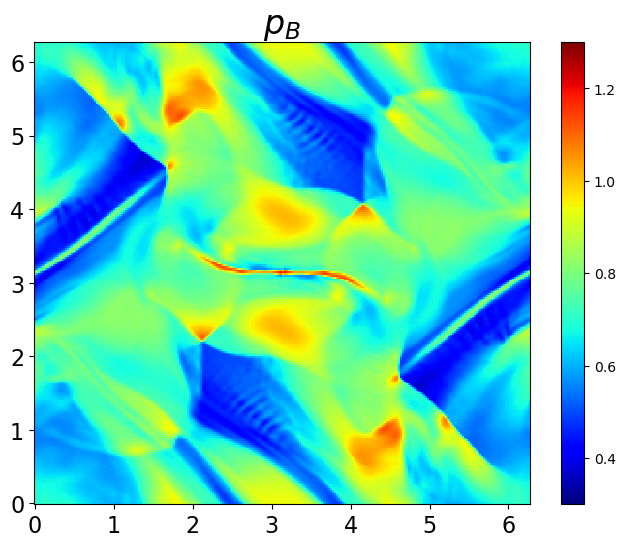

In [20]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

step = 1000
U = np.load(f"results_orszag-tang/U_{step}.npy")
rho = U[0, :, :]
u = U[1, :, :] / rho
v = U[2, :, :] / rho
w = U[3, :, :] / rho
Bx = U[4, :, :]
By = U[5, :, :]
Bz = U[6, :, :]
e = U[7, :, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
magnetic_pressure = 1/2 * (Bx**2+By**2+Bz**2)
pT = p + magnetic_pressure

contour = ax1.pcolormesh(X, Y, (p/rho).T, vmin=0.3, vmax=1.3, cmap='jet')
cbar = plt.colorbar(contour, ax=ax1)

ax1.set_title(r"$p_B$", fontsize=24)
ax1.tick_params(labelsize=16)
plt.show()

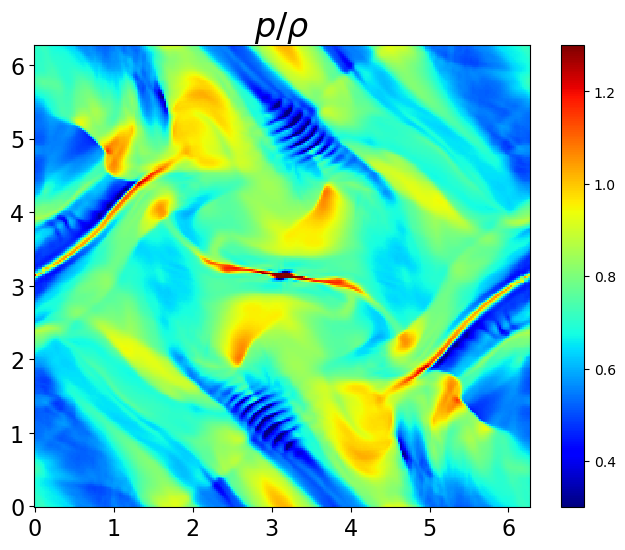

In [22]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

total_steps = 1200
interval = 10
for step in range(0, total_steps+interval, interval):
    ax1.clear()

    U = np.load(f"results_orszag-tang/U_{step}.npy")
    rho = U[0, :, :]
    u = U[1, :, :] / rho 
    v = U[2, :, :] / rho 
    w = U[3, :, :] / rho 
    Bx = U[4, :, :]
    By = U[5, :, :]
    Bz = U[6, :, :]
    e = U[7, :, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
    magnetic_pressure = 1/2 * (Bx**2+By**2+Bz**2)
    pT = p + magnetic_pressure

    #contour = ax1.pcolormesh(X, Y, (rho).T, vmin=2.0, vmax=5.0, cmap='jet')
    #contour = ax1.pcolormesh(X, Y, (magnetic_pressure).T, vmin=0.0, vmax=3.0, cmap='jet')
    contour = ax1.pcolormesh(X, Y, (p/rho).T, vmin=0.3, vmax=1.3, cmap='jet')
    if step == 0:
        cbar = plt.colorbar(contour, ax=ax1)

    ax1.set_title(r"$p/\rho$", fontsize=24)
    ax1.tick_params(labelsize=16)

    fig.savefig(f"pictures/{step}.png", dpi=200)


filename = "orszag-tang_p-rho.mp4"
img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 10.0
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for step in range(0, total_steps+interval, interval):
    img = cv2.imread(f'./pictures/{step}.png')
    video.write(img)
video.release()